#  Logistic Regression and Classification Error Metrics

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website: above or at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones 

In [1]:
from __future__ import print_function
import os
#Data Path has to be set as per the file location in your system
#data_path = ['..', 'data']
data_path = ['./']

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [2]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [3]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [4]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [5]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [6]:
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [7]:
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

846     5
5000    3
2647    3
6719    0
1321    2
Name: Activity, dtype: int32

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [9]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

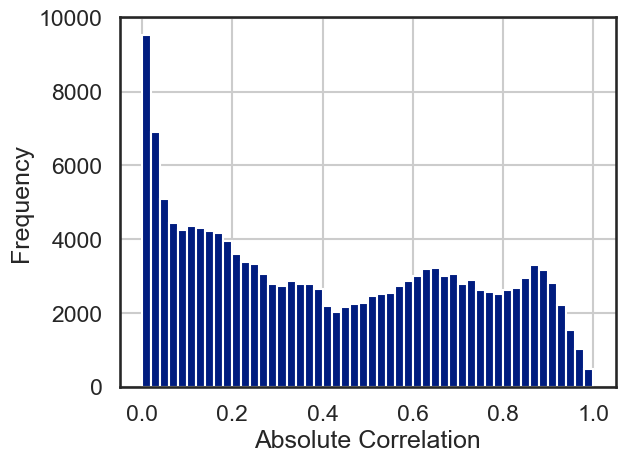

In [11]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [12]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']


In [14]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: Activity, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [16]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(max_iter=500, penalty='none').fit(X_train, y_train)
lr.coef_

array([[ -62.63539914,    9.91270507,   13.9559209 , ...,  640.78369718,
        -259.62827938,  -86.55788191],
       [-199.50322175,  -82.02279843,   18.45123385, ...,  -76.08019402,
         -96.50578188,  -62.59479552],
       [  86.1627037 ,   66.73293448,   71.38394394, ..., -253.39883894,
         191.12194016,   22.78635479],
       [   8.6993861 ,  -12.52474866,    0.65135991, ..., -117.59564394,
          22.66352925,   58.1935174 ],
       [ 118.12626473,   25.10999372,    1.78219738, ..., -216.34797261,
         -10.95506804,   -6.06595059],
       [  49.15026636,   -7.20808618, -106.22465598, ...,   22.63895232,
         153.30365989,   74.23875583]])

In [17]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [18]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

# newton-cg
# 4 folds
# penalty l2
newton = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000, solver='newton-cg').fit(X_train, y_train)

In [19]:
# lbfgs
# 4 folds
# penalty l2
lbfgs = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000, solver='lbfgs').fit(X_train, y_train)

In [20]:
# sag
# 4 folds
# penalty l2
sag = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000, solver='sag').fit(X_train, y_train)

In [21]:
# saga
# 4 folds
# penalty l2
saga = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000, solver='saga').fit(X_train, y_train)

In [22]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train, y_train)

## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [24]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2', 'newton-cg', 'lbfgs', 'sag', 'saga']
coeff_models = [lr, lr_l1, lr_l2, newton, lbfgs, sag, saga]

#for lab,mod in zip(coeff_labels, coeff_models):
#    coeffs = mod.coef_
#    levels=[[lab], [0,1,2,3,4,5]]
#    labels=[[0,0,0,0,0,0], [0,1,2,3,4,5]]
#    coeff_label = pd.MultiIndex(levels,labels)
#    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)



lr                                                             \
             0           1           2          3           4           5   
98    6.734870   30.415531   37.651356 -34.047180   23.460754  -64.215332   
416  21.300596   41.771711   53.404744 -82.782013    8.778569  -42.473607   
527 -14.521452   -6.438159   -7.959619 -12.399736  200.134743 -158.815777   
149  56.168383   40.360552  -14.420901 -64.837164   37.600188  -54.871058   
540  57.529460  194.565437 -109.612042  17.938219 -114.437701  -45.983372   
441 -12.512549   -7.480338   34.651784 -17.380674  -18.662178   21.383954   
471  19.978848   43.626534   46.369957 -16.979133  -67.274583  -25.721623   
26  -55.305601  -61.599040   67.939763  67.054432  -87.567520   69.477966   
334  20.048988   42.615859   49.887887 -25.301218   -7.136610  -80.114906   
113  33.381809   97.448854   -0.278289 -16.444250  -41.615187  -72.492938   

           l1                                ...       sag            \
            0         1         2         3  ...         2         3   
98   0.000000  0.000000  0.000000  0.000000  ...  0.061812 -0.027556   
416 -0.012139  0.350541  0.707030  0.000000  ...  0.073824 -0.130897   
527  0.000000  0.000000  0.162422  0.000000  ...  0.095037  0.170173   
149  0.000000 -0.004178  2.344866  0.000000  ...  0.486121 -0.296389   
540  0.000000  0.000000  0.000000  0.146642  ... -0.336960  0.096807   
441  0.000000  0.000000  0.000000  0.000000  ...  0.092833 -0.032559   
471  0.000000  0.150624  0.421856  0.000000  ...  0.056561 -0.030547   
26   0.000000  0.000000  0.000000  0.000000  ... -0.070540  0.008379   
334  0.000000  0.050433  0.215520  0.000000  ...  0.072698  0.103195   
113  0.000000  0.000000  0.000000  0.000000  ...  0.168846  0.030955   

                             saga                                          \
            4         5         0         1         2         3         4   
98   0.165198 -0.146177 -0.069288  0.017858  0.066973 -0.031176  0.162348   
416  0.223327 -0.132401 -0.068941  0.037433  0.079070 -0.136123  0.216427   
527  0.532235 -0.729292 -0.100981  0.029128  0.098886  0.171708  0.535183   
149  0.237802  0.026773  0.133253 -0.594113  0.495274 -0.294545  0.236495   
540 -0.261427 -0.091759  0.128166  0.449436 -0.318907  0.097787 -0.264760   
441 -0.048899  0.097543 -0.064003 -0.041044  0.093829 -0.034414 -0.051563   
471 -0.074495  0.086677 -0.067322  0.031425  0.061669 -0.032392 -0.079069   
26  -0.287650  0.278129 -0.093175  0.178953 -0.085465  0.011346 -0.288147   
334  0.029086 -0.178321 -0.063186  0.038468  0.078291  0.097933  0.025285   
113  0.062206 -0.192145  0.044428 -0.123337  0.181391  0.030067  0.061150   

               
            5  
98  -0.146716  
416 -0.127865  
527 -0.733923  
149  0.023637  
540 -0.091722  
441  0.097196  
471  0.085688  
26   0.276487  
334 -0.176791  
113 -0.193700  

[10 rows x 42 columns]

Prepare six separate plots for each of the multi-class coefficients.

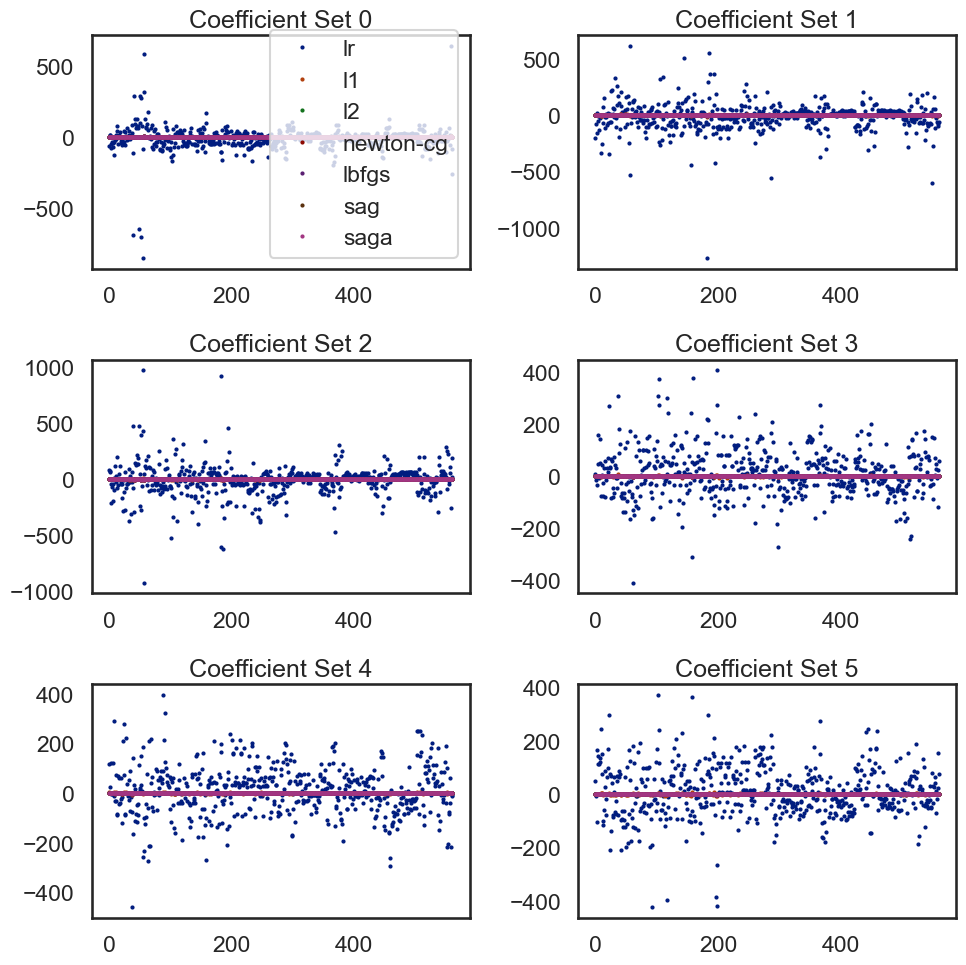

In [25]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data_aux = coefficients.xs(loc, level=1, axis=1)
    data_aux.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()




## Question 6

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [26]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2', 'newton-cg', 'lbfgs', 'sag', 'saga']
coeff_models = [lr, lr_l1, lr_l2, newton, lbfgs, sag, saga]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()



,lr,l1,l2,newton-cg,lbfgs,sag,saga
0,3,3,3,3,3,3,3
1,5,5,5,5,5,5,5
2,3,3,3,3,3,3,3
3,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0


In [27]:
y_prob.head()

,lr,l1,l2,newton-cg,lbfgs,sag,saga
0,1.0,0.998908,0.999998,0.999999,0.999998,0.999997,0.999997
1,1.0,0.999595,0.999655,0.999650,0.999655,0.999652,0.999649
2,1.0,0.995564,0.998875,0.998874,0.998875,0.998826,0.998816
3,1.0,0.999173,0.997828,0.997837,0.997828,0.997734,0.997660
4,1.0,0.999923,0.999299,0.999326,0.999299,0.999159,0.999153


## Question 7

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [28]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)


In [29]:
#Run the metrics
metrics

,lr,l1,l2,newton-cg,lbfgs,sag,saga
precision,0.983490,0.983833,0.983485,0.983485,0.983485,0.983161,0.983161
recall,0.983495,0.983819,0.983495,0.983495,0.983495,0.983172,0.983172
fscore,0.983490,0.983817,0.983488,0.983488,0.983488,0.983165,0.983165
accuracy,0.983495,0.983819,0.983495,0.983495,0.983495,0.983172,0.983172
auc,0.989997,0.990148,0.989983,0.989983,0.989983,0.989787,0.989787


## Question 8

Display or plot the confusion matrix for each model.

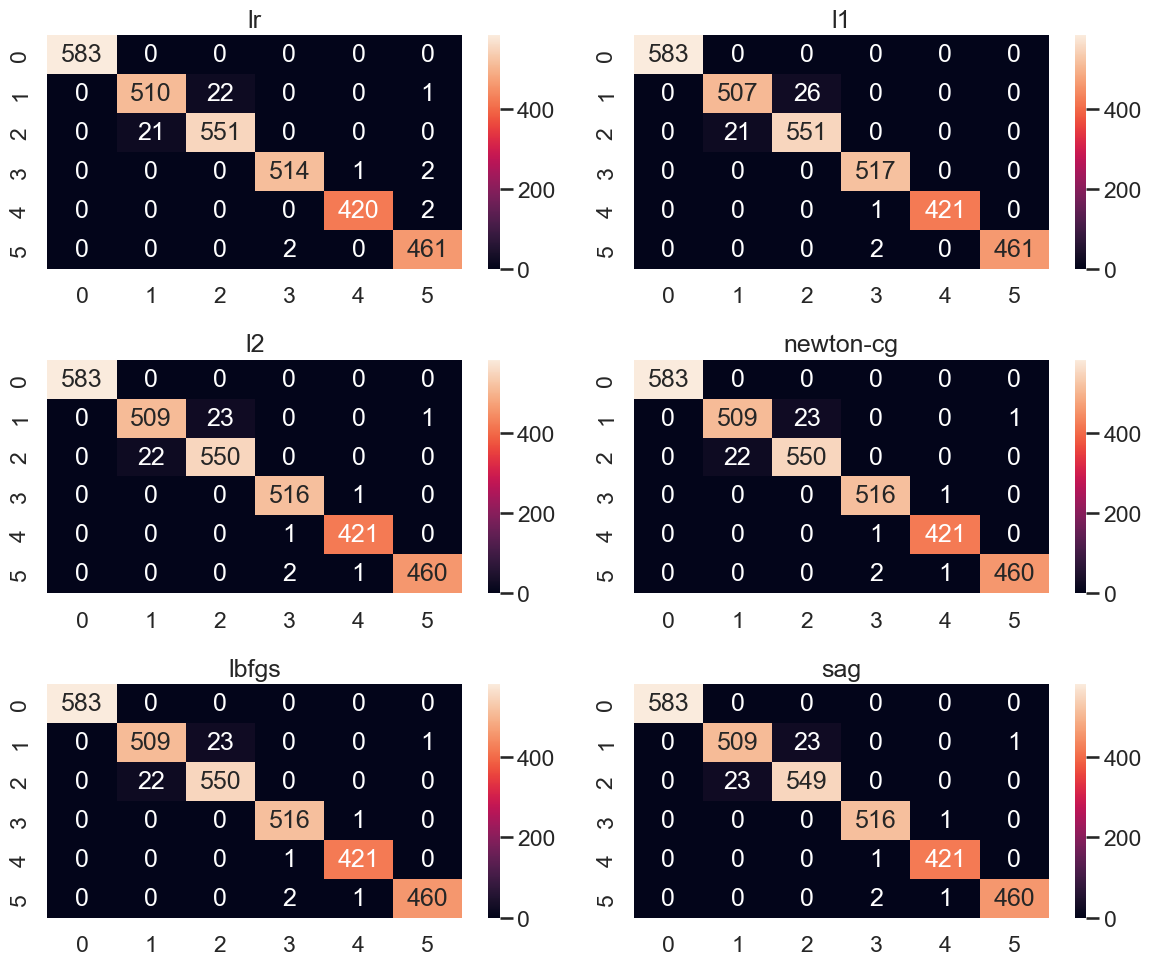

In [76]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

#axList[-1].axis('off')

for ax,lab in zip(axList, coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()

## Question 9
 Identify highly correlated columns and drop those columns before building models

In [55]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold


X_data = data.iloc[:, :-1]


#threshold with .7
sel = VarianceThreshold(threshold=(.7 * (1 - .7)))
X_data = pd.DataFrame(sel.fit_transform(X_data))


feature_cols = X_data.columns[:]


# Dividindo os subjconjuntos de treino e teste, seguindo os mesmos
# Indices obtidos com Stratified Shuffle Split, agora com os dados
# Com menos features
 

X_train_new = X_data.loc[train_idx, :]

y_train_new = data.loc[train_idx, 'Activity']
 
X_test_new  = X_data.loc[test_idx, :]
y_test_new  = data.loc[test_idx, 'Activity']
 
print(X_train.shape)
print(X_train_new.shape)
 
print(X_test.shape)
print(X_test_new.shape)

(7209, 561)
(7209, 50)
(3090, 561)
(3090, 50)


 Repeat Model building with new training data after removing higly correlated columns

In [59]:
import warnings

warnings.filterwarnings('ignore')

# Try standard, L1 and L2 Logistic regression

# Standard logistic regression
lr_new = LogisticRegression(max_iter=500, penalty='none').fit(X_train_new, y_train_new)

In [60]:
# L1 regularized logistic regression
# 4 folds
# penalty l1
# 500 interations
lr_l1_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train_new, y_train_new)

In [61]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

# modelo newton-cg
# 4 folds
# penalty l2
newton_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000, solver='newton-cg').fit(X_train_new, y_train_new)

In [62]:
# lbfgs
# 4 folds
# penalty l2
lbfgs_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000, solver='lbfgs').fit(X_train_new, y_train_new)

In [63]:
# sag
# 4 folds
# penalty l2
sag_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000, solver='sag').fit(X_train_new, y_train_new)

In [64]:
# saga
# 4 folds
# penalty l2
saga_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000, solver='saga').fit(X_train_new, y_train_new)

In [65]:
# L2 regularized logistic regression
lr_l2_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train_new, y_train_new)

## Question 10

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [66]:
# Combine all the coefficients into a dataframe for comparison

# Combine all the coefficients into a dataframe
coefficients_new = list()

coeff_labels_new = ['lr', 'l1', 'l2', 'newton-cg', 'lbfgs', 'sag', 'saga']
coeff_models_new = [lr_new, lr_l1_new, lr_l2_new, newton_new, lbfgs_new, sag_new, saga_new]

coeff_labels_new = ['lr', 'l1', 'l2', 'newton-cg', 'saga', 'sag']
coeff_models_new = [lr_new, lr_l1_new, lr_l2_new, newton_new, saga_new, sag_new]

for lab,mod in zip(coeff_labels_new, coeff_models_new):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients_new.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients_new = pd.concat(coefficients_new, axis=1)

coefficients_new.sample(10)

lr                                                             l1  \
            0         1         2          3          4          5         0   
6   -6.858867  9.459520 -3.437073 -34.658800  13.880124  21.615097  0.000000   
10   1.478100  1.077961  1.561045  -1.130132  -1.779240  -1.207735  0.000000   
21   1.897683 -0.942060 -0.369865  -8.026360   8.134988  -0.694386  0.000000   
5  -11.673370 -3.603610  9.219703  -3.131400  -0.955024  10.143700 -2.087999   
26  -0.754090 -1.811796 -4.645520  17.816933   8.406269 -19.011797  0.000000   
47  -1.359219  0.678261  0.536588  -0.222608   0.305980   0.060997  0.000000   
3    1.050322 -0.655316  0.254855 -26.260490  11.939600  13.671030  0.000000   
46  -1.159553  1.599453  0.081376   0.757927   4.497070  -5.776272  0.000000   
39  -1.906163 -0.685120 -1.724541   7.727122   5.590461  -9.001759  0.000000   
28   0.018144 -3.832087  1.050292   3.097057  -1.756913   1.423507  0.000000   

                                     ...       saga                        \
            1          2          3  ...          2          3          4   
6   16.054710   2.002376 -65.579851  ... -10.460864 -57.030974  29.809901   
10  -0.513248   0.533580   0.108346  ...   0.968482  -0.717108  -1.414197   
21  -1.131350   1.358508  -7.681115  ...   1.236116  -9.121111   7.244963   
5   75.412841  10.896564   0.434510  ...   5.969731  -2.161275  -2.696156   
26   2.674150  -2.643016  23.082117  ...  -4.252856  15.871695   7.266616   
47   0.232790  -0.233163  -0.319929  ...   0.152948  -0.108881   0.400898   
3   -2.998097   0.000000 -57.453210  ...   2.860373 -33.188382  16.681903   
46   1.249113  -0.486437   0.843112  ...  -0.016965  -0.299545   4.192369   
39   1.370298  -1.823735  10.860712  ...  -2.113516   6.535482   5.591713   
28  -5.269057   5.209754   7.671420  ...   2.057334   3.225901  -1.301877   

                    sag                                                         
            5         0          1          2          3          4          5  
6   25.792698 -5.030711  19.743400 -12.872026 -69.444125  37.004565  30.598896  
10  -0.793380  1.474186   0.352031   0.856887  -0.596730  -1.355751  -0.730623  
21  -1.201382  1.451746   0.736322   1.563406  -9.706359   7.183442  -1.228558  
5    8.575825 -8.700824   2.350607   2.393567  -3.992727  -3.086151  11.035527  
26 -16.549736 -1.050990  -1.503758  -4.494664  16.084866   7.429737 -16.465192  
47   0.172156 -1.060228   0.348362   0.141913  -0.091598   0.441420   0.220132  
3   13.679533  1.661565  -2.572670   4.118118 -35.662972  18.071094  14.384866  
46  -4.573044 -0.649173   1.398449   0.121757  -0.491798   4.202569  -4.581804  
39  -8.257499 -1.019658  -0.896229  -2.286344   6.914207   5.627259  -8.339236  
28   0.312470 -0.849216  -3.427586   2.071979   3.564222  -1.518773   0.159375  

[10 rows x 36 columns]

Prepare six separate plots for each of the multi-class coefficients.

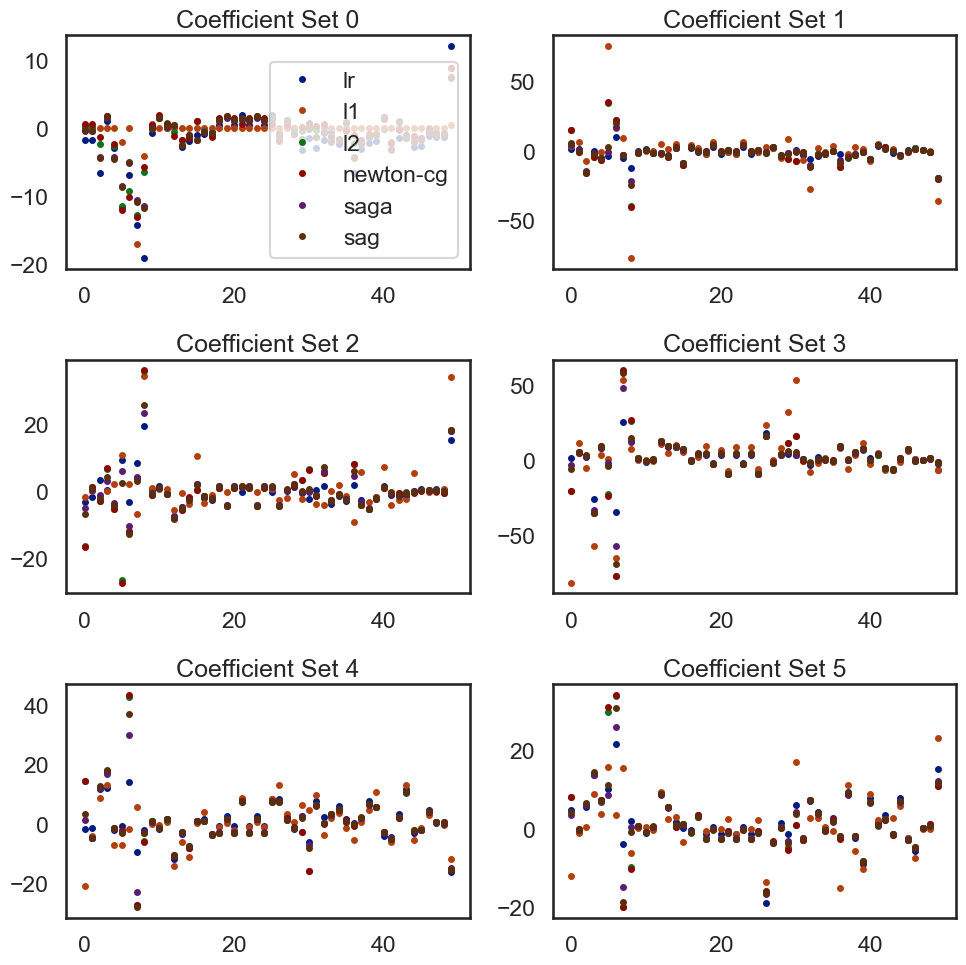

In [67]:
# try the plots

fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data_aux = coefficients_new.xs(loc, level=1, axis=1)
    data_aux.plot(marker='o', ls='', ms=4.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()

## Question 11

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [68]:
# Predict the class and the probability for each

y_pred_new = list()
y_prob_new = list()

coeff_labels_new = ['lr', 'l1', 'l2', 'newton-cg', 'lbfgs', 'sag', 'saga']
coeff_models_new = [lr_new, lr_l1_new, lr_l2_new, newton_new, lbfgs_new, sag_new, saga_new]

for lab,mod in zip(coeff_labels_new, coeff_models_new):
    y_pred_new.append(pd.Series(mod.predict(X_test_new), name=lab))
    y_prob_new.append(pd.Series(mod.predict_proba(X_test_new).max(axis=1), name=lab))
    
y_pred_new = pd.concat(y_pred_new, axis=1)
y_prob_new = pd.concat(y_prob_new, axis=1)

y_pred_new.head()

,lr,l1,l2,newton-cg,lbfgs,sag,saga
0,3,3,3,3,3,3,3
1,5,5,5,5,5,5,5
2,3,3,3,3,3,3,3
3,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0


In [69]:
y_prob_new.head()

,lr,l1,l2,newton-cg,lbfgs,sag,saga
0,0.999993,0.997268,0.999993,0.999993,0.999993,0.999992,0.999989
1,0.999953,0.998145,0.999868,0.999867,0.999868,0.999882,0.999873
2,0.999958,0.986530,0.999982,0.999982,0.999982,0.999977,0.999963
3,0.853573,0.871575,0.877095,0.877625,0.877095,0.873624,0.870606
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999999


## Question 12

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [70]:
# Calculate the error metrics as listed above

metrics_new = list()
cm_new = dict()

for lab in coeff_labels_new:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test_new, y_pred_new[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test_new, y_pred_new[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test_new, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred_new[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm_new[lab] = confusion_matrix(y_test_new, y_pred_new[lab])
    
    metrics_new.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics_new = pd.concat(metrics_new, axis=1)

In [71]:
#Run the metrics
metrics_new

,lr,l1,l2,newton-cg,lbfgs,sag,saga
precision,0.935386,0.937672,0.937285,0.936643,0.937285,0.937918,0.937893
recall,0.935275,0.937540,0.937217,0.936570,0.937217,0.937864,0.937864
fscore,0.935272,0.937554,0.937198,0.936555,0.937198,0.937849,0.937838
accuracy,0.935275,0.937540,0.937217,0.936570,0.937217,0.937864,0.937864
auc,0.961189,0.962470,0.962340,0.961954,0.962340,0.962714,0.962707


## Question 13

Display or plot the confusion matrix for each model.

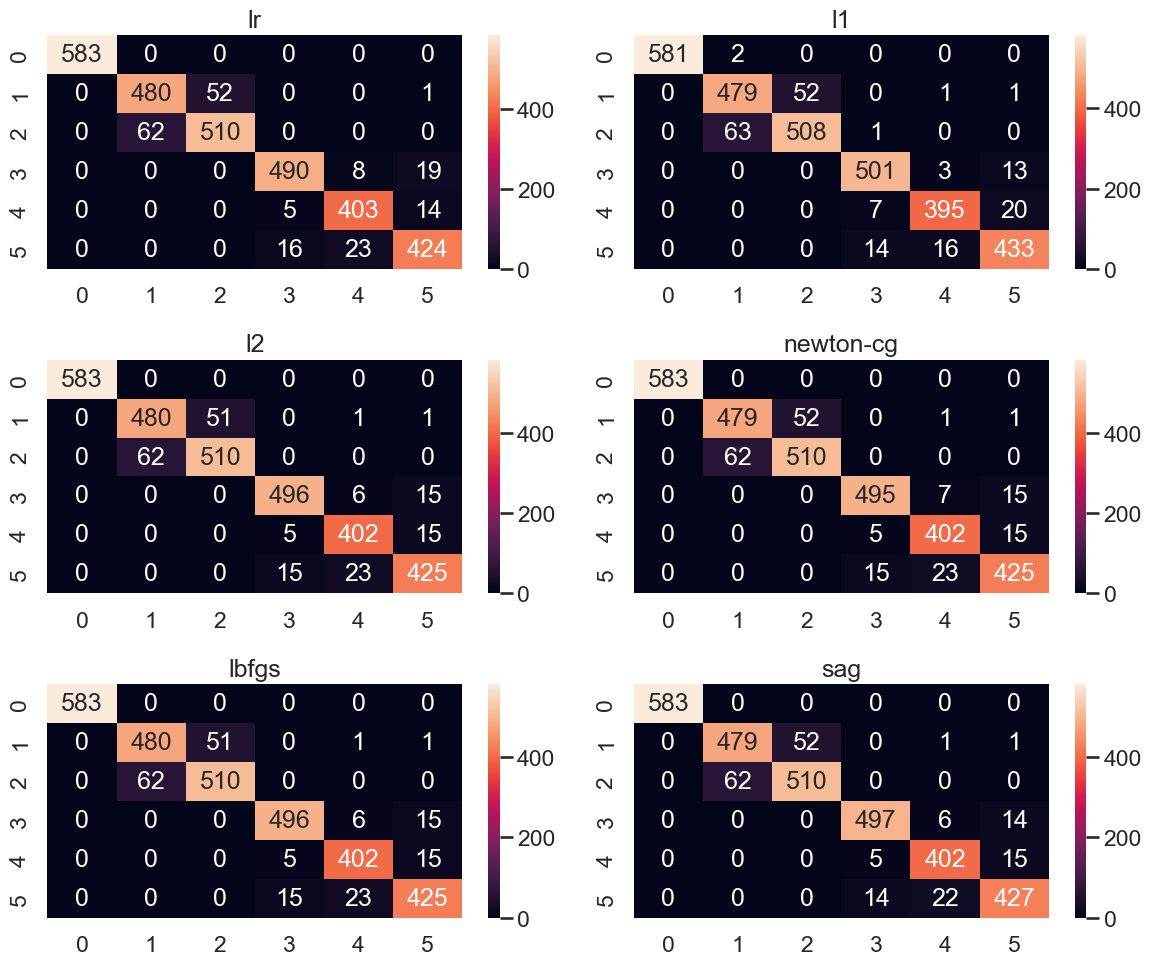

In [72]:
#plot the confusion matrix

fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

#axList[-1].axis('off')

for ax,lab in zip(axList, coeff_labels_new):
    sns.heatmap(cm_new[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()

In [73]:
# Perform a comparison of the outputs between Question 7 and 12 and give your observation

# métricas da questão 07
metrics

,lr,l1,l2,newton-cg,lbfgs,sag,saga
precision,0.983490,0.983833,0.983485,0.983485,0.983485,0.983161,0.983161
recall,0.983495,0.983819,0.983495,0.983495,0.983495,0.983172,0.983172
fscore,0.983490,0.983817,0.983488,0.983488,0.983488,0.983165,0.983165
accuracy,0.983495,0.983819,0.983495,0.983495,0.983495,0.983172,0.983172
auc,0.989997,0.990148,0.989983,0.989983,0.989983,0.989787,0.989787


In [74]:
# métricas da questão 12
metrics_new

,lr,l1,l2,newton-cg,lbfgs,sag,saga
precision,0.935386,0.937672,0.937285,0.936643,0.937285,0.937918,0.937893
recall,0.935275,0.937540,0.937217,0.936570,0.937217,0.937864,0.937864
fscore,0.935272,0.937554,0.937198,0.936555,0.937198,0.937849,0.937838
accuracy,0.935275,0.937540,0.937217,0.936570,0.937217,0.937864,0.937864
auc,0.961189,0.962470,0.962340,0.961954,0.962340,0.962714,0.962707


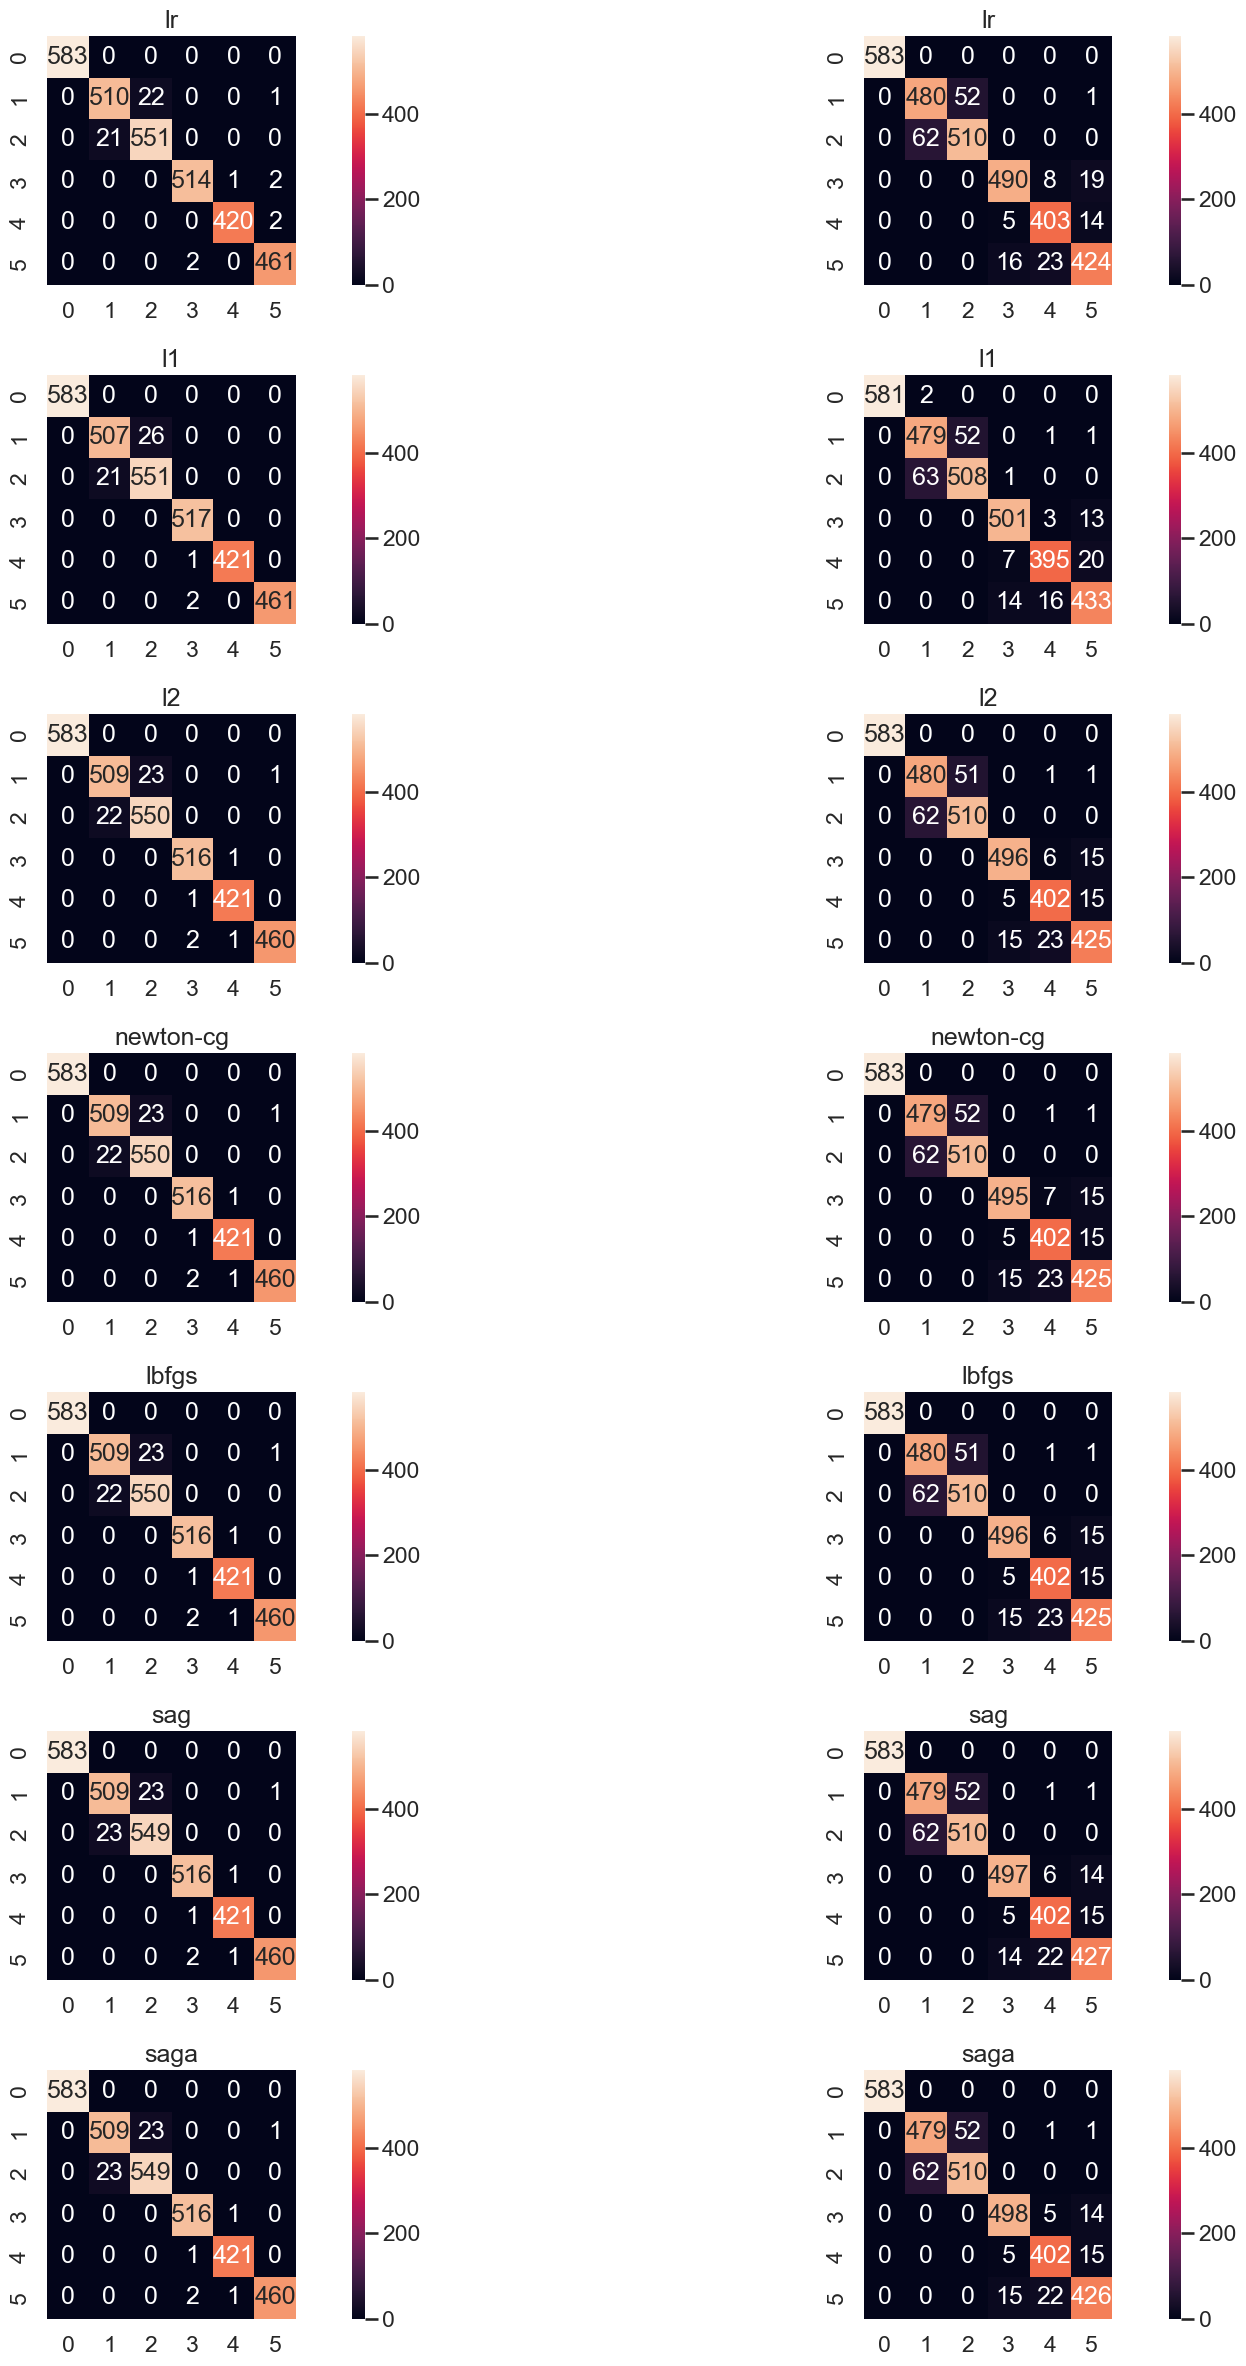

In [87]:
# Perform a comparison of the outputs between Question 8 and 13 and give your observation

fig, axList = plt.subplots(nrows=7, ncols=2)
axList = axList.flatten()
fig.set_size_inches(20, 24)

for count, lab in enumerate(coeff_labels):

    # questão 8
    sns.heatmap(cm[lab], ax=axList[count * 2], cbar=True, square=True, annot=True, fmt='d')
    axList[count * 2].set(title=lab)

    # questão 13
    sns.heatmap(cm_new[lab], ax=axList[count * 2 + 1], cbar=True, square=True, annot=True, fmt='d')
    axList[count * 2 + 1].set(title=lab)
    
plt.tight_layout()


In [84]:
# média dos erros com todas as features
y_prob.mean(axis=0)

lr           0.999936
l1           0.979348
l2           0.979940
newton-cg    0.979944
lbfgs        0.979940
sag          0.979807
saga         0.979710
dtype: float64

In [85]:
# média dos erros com features selecionadas
y_prob_new.mean(axis=0)

lr           0.940506
l1           0.921120
l2           0.942706
newton-cg    0.942776
lbfgs        0.942706
sag          0.942431
saga         0.941477
dtype: float64

In [86]:
# diferença entre as médias
y_prob.subtract(y_prob_new).mean(axis=0)

lr           0.059430
l1           0.058228
l2           0.037234
newton-cg    0.037168
lbfgs        0.037234
sag          0.037377
saga         0.038234
dtype: float64